In [10]:
import apgpy as apg
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Generate some data

In [11]:
n = 1000
d = 250
mu = 0.1
x_n = -0.1 * np.random.rand(d)
x_p = 0.1 * np.random.rand(d)
X_p = 5 * np.random.randn(d, n) + np.tile(x_p, (n, 1)).T
X_n = 5 * np.random.randn(d, n) + np.tile(x_n, (n, 1)).T
X = np.hstack((X_p, -X_n))

Define gradient operator

In [12]:
def log_reg_grad(y):
    v = np.exp(-np.dot(X.T, y))
    return np.dot(X, 1 / (1 + v) / 2 / n)

Define proximal operator

In [13]:
def soft_thresh(y, t):
    return np.sign(y) * np.maximum(abs(y) - t * mu, 0)

Solve!

iter num 0, norm(Gk)/(1+norm(xk)): nan, step-size: 4.38e-01
iter num 34, norm(Gk)/(1+norm(xk)): 9.81e-13, step-size: 9.35e-02
terminated


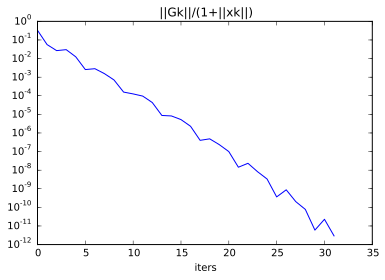

In [14]:
x = apg.solve(log_reg_grad, soft_thresh, d, eps = 1e-12)

iter num 0, norm(Gk)/(1+norm(xk)): nan, step-size: 4.38e-01
iter num 73, norm(Gk)/(1+norm(xk)): 7.58e-13, step-size: 9.75e-02
terminated


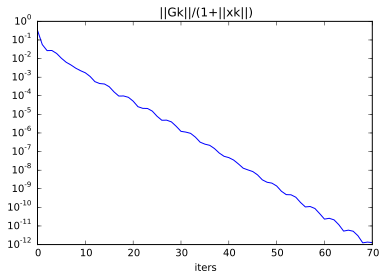

In [15]:
x_no_restart = apg.solve(log_reg_grad, soft_thresh, d, use_restart = False, eps = 1e-12)

Compare to ECOS (second order solver) and SCS (another first-order solver):

In [16]:
import cvxpy as cp

print(sum(cp.log_sum_exp(cp.vstack(0, np.dot(X[:, i].T, x))).value for i in range(2 * n)) / 2 / n + mu * cp.norm(x, 1).value)

z = cp.Variable(d)
objective = cp.Minimize(sum(cp.log_sum_exp(cp.vstack(0, X[:, i].T*z)) for i in range(2 * n)) / 2 / n + mu * cp.norm(z, 1))
p = cp.Problem(objective)

p.solve(verbose=True, solver=cp.ECOS)  # not very accurate for some reason
print(sum(cp.log_sum_exp(cp.vstack(0, X[:, i].T*z)).value for i in range(2 * n)) / 2 / n + mu * cp.norm(z, 1).value)
z_ecos = z.value.A1

p.solve(verbose=True, solver=cp.SCS, use_indirect=True)
print(sum(cp.log_sum_exp(cp.vstack(0, X[:, i].T*z)).value for i in range(2 * n)) / 2 / n + mu * cp.norm(z, 1).value)
z_scs = z.value.A1


0.692000658208

ECOS 2.0.1 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -4.226e+03  +1e+04  6e-01  2e+00  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +2.185e+01  -2.622e+03  +6e+03  3e-01  2e+00  9e-01  4e-01  0.6266  8e-02   1  1  1 |  2  2
 2  +3.446e+01  -1.357e+03  +3e+03  1e-01  1e+00  5e-01  2e-01  0.6266  1e-01   1  1  0 |  3  2
 3  +3.063e+01  -5.253e+02  +1e+03  4e-02  7e-01  2e-01  8e-02  0.6266  1e-01   1  1  1 |  2  2
 4  +1.761e+01  -1.027e+02  +3e+02  8e-03  6e-01  6e-02  2e-02  0.7833  5e-02   1  0  0 |  1  1
 5  +1.025e+01  -3.795e+01  +1e+02  3e-03  5e-01  2e-02  9e-03  0.6266  7e-02   0  0  0 |  2  2
 6  +5.217e+00  -7.122e-01  +2e+01  4e-04  1e-01  3e-03  1e-03  0.8884  2e-02   0  0  0 |  1  0
 7  +4.386e+00  +3.601e-01  +1e+01  3e-04  9e-02  2e-03  8e-04  0.4010  4e-01   1  0  0 |  3  4
 8  +2.973e+00  +1.627e+00  +5e

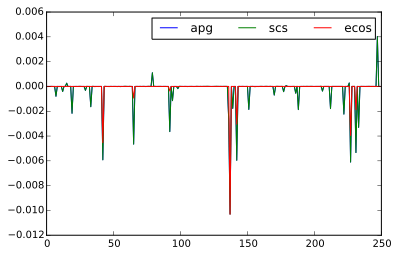

In [17]:
plt.plot(x, label='apg')
plt.plot(z_scs, label='scs')
plt.plot(z_ecos, label='ecos')
plt.legend(ncol=3)